<center>
    <h1>Rossmann Store Sales - Time Series Analysis and Forecasts</h1>
    <h2>By: Adam Kacprzycki</h2>
    <h2>Part II - Models </h2>
</center>

# Modeling and Hyperparameter Tuning

This notebook represents a natural next step in the data science project, building upon the knowledge and insights gained during the exploratory data analysis (EDA) phase.

In this notebook, I will explore several simple models for sales prediction, which serve as initial or baseline models before considering more advanced approaches. The models examined include:

<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px;">
    <ul style="list-style-type: none;">
        <li><strong>1. Dummy Regressor (based on mean and median)</strong></li>
        <li><strong>2. Linear Regression and Ridge Regression</strong></li>
        <li><strong>3. Decision Tree Regressor</strong></li>
        <li><strong>4. Random Forest Regressor (with hyperparameter tuning)</strong></li>
    </ul>
</div>

Moving towards more advanced models, I have incorporated gradient boosting techniques, specifically:

Multivariate models:

<div style="background-color: #f7f7f7; padding: 10px; border-radius: 5px;">
    <ul style="list-style-type: none;">
        <li><strong>5. LGBMRegressor (with hyperparameter tuning)</strong></li>
        <li><strong>6. XGBRegressor (with hyperparameter tuning)</strong></li>
    </ul>
</div>

These gradient boosting models are known for their ability to effectively handle complex regression tasks and provide improved predictive performance compared to the simpler models mentioned earlier. Through hyperparameter tuning, I aimed to optimize the models' performance and achieve more accurate sales predictions.


In total, six models were implemented and tested in this project. These models were carefully chosen to cover a range of techniques and approaches in order to evaluate their performance and suitability for the task at hand.

<!-- Block colors -->
<div style="display: none;">
    <a href="https://www.colorhexa.com/f7f7f7">Link</a>
</div>

[_magic_of_random_state_42_:)](https://en.wikipedia.org/wiki/Phrases_from_The_Hitchhiker%27s_Guide_to_the_Galaxy#Answer_to_the_Ultimate_Question_of_Life,_the_Universe,_and_Everything_(42))

___

### Imports:

In [1]:
# base tools:
import pandas as pd
import numpy as np
import utils as utl #module with user's custom func
from datetime import datetime, timedelta

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt

#modeling data preprocessing
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
import category_encoders as ce
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import TransformedTargetRegressor

#pipes:
from sklearn.pipeline import Pipeline

# feature selection
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold, SelectKBest, RFE
import eli5
from eli5.sklearn import PermutationImportance

# base models:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor

# more advenced models:
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgbm
from lightgbm import LGBMRegressor, plot_importance
import xgboost as xgb
from xgboost import XGBRegressor

# hypertining parameters & eval
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

#user settings:
pd.set_option('display.max_columns', None, "display.max_rows", 50)

2023-06-19 16:16:18.898609: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Business metric (futher described in EDA part):
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(((y_true - y_pred) / y_true) ** 2))

___

### Data loading:

In [3]:
# Datasets:
df_sales = pd.read_csv('data/train.csv', parse_dates=['Date'], low_memory = False) # base data containing information about sales
df_store = pd.read_csv('data/store.csv', low_memory = False) # detailed description of store
df_test  = pd.read_csv('data/test.csv', parse_dates=['Date'], low_memory = False) # test set

In [4]:
# Data Merging:
df = df_sales.merge(right=df_store, on="Store", how="left").reset_index(drop=True)

____

### Data cleaning:

The preprocessing steps undertaken in this project are the outcome of comprehensive exploratory data analysis (EDA).

#### Missing values:


I have decided to consolidate all the transformations mentioned below into a single line, as the transformations (`.fillna(0,...`) remain consistent for the five features. However, it should be noted that the first one, which pertains to 'CompetitionDistance,' only takes into account three observations. Therefore, due to this fact, the combination of it should not bias the results.

In [5]:
# The transformation of missing values was combined:

df.fillna(value=0, inplace=True)

# The transformations of missing values established during the EDA were as follows:

# df['CompetitionDistance'].fillna(value = df['CompetitionDistance'].median(), inplace=True) #With only three observations, it is unlikely that they would significantly contribute to the model.
# df['CompetitionOpenSinceYear'].fillna(0, inplace = True) #Below comment: how does it influence the data
# df['CompetitionOpenSinceMonth'].fillna(0,inplace=True)
# df["Promo2SinceWeek"].fillna(value = 0, inplace=True)
# df["Promo2SinceYear"].fillna(value = 0, inplace=True)
# df["PromoInterval"].fillna(value = 0, inplace=True)

#### Zero sales stores:

Including observations without sales in the model serves no purpose as they do not provide any valuable contribution and can potentially introduce unnecessary bias.

In [6]:
#Filtering Sales grater than 0 and not equal to 0:

df = df.loc[(df.Open != 0) & (df.Sales > 0)]

____

### Feature Engineering:

In [7]:
#Date extraction (based on EDA):

def extract_dates(df: pd.DataFrame) -> int:
    
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['WeekOfYear'] = df.Date.dt.isocalendar().week.astype('int')
    
extract_dates(df)

# Comment: As a result of extracting information from the aforementioned column 'Date', it is deemed unnecessary to retain this column.
# TO DO: to drop: Date (preliminary feature selection step)

In [8]:
# Calculate time competition open time in months (new feature)

def comp_open_months(df: pd.DataFrame) -> float:
    
    df['CompOpenInMonth'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth) #in case of values inputet by 0 return year 1900 and retur as result high value, howerer this should be indicated as observation without data (outstanding) values
    df['CompOpenInMonth'] = df['CompOpenInMonth'].map(lambda x: 0 if x < 0 else x).fillna(0) #if Year+Month of observation < CompetitionOpenSinceYear + CompetitionOpenSinceMonth (Competition do not exist at that moment)
    
comp_open_months(df)

# Comment: As a result of extracting information from the aforementioned columns, it is deemed unnecessary to retain these columns.
# TO DO: to drop: CompetitionOpenSinceYear, CompetitionOpenSinceMonth (preliminary feature selection step)

In [9]:
# Promo open time in months (new feature)

def promo_open(df: pd.DataFrame) -> float:
    
    df['PromoOpenInMonth'] = 12 * (df.Year - df.Promo2SinceYear) + (df.WeekOfYear - df.Promo2SinceWeek) / float(4) #same issua as CompetitionOpen
    df['PromoOpenInMonth'] = df['PromoOpenInMonth'].apply(lambda x: x if x > 0 else 0) # #same issua as CompetitionOpen

promo_open(df)

# Comment: As a result of extracting information from the aforementioned columns, it is deemed unnecessary to retain these columns.
# TO DO: to drop: Promo2SinceYear, Promo2SinceWeek (preliminary feature selection step)

In [10]:
# Indicate if Promo2 is active:

def promo_2_flag(df: pd.DataFrame) -> float:
    
    month2str = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
    df['monthStr'] = df['Month'].map(month2str)
    df['PromoInterval'] = df['PromoInterval'].astype(str)  # Conversion to str data type
    df.loc[df['PromoInterval'] == '0', 'PromoInterval'] = ''
    df['Promo2Active'] = 0

    for interval in df['PromoInterval'].unique():
        if interval != '':
            for month in interval.split(','):
                df.loc[(df['monthStr'] == month) & (df['PromoInterval'] == interval), 'Promo2Active'] = 1

    df.drop('monthStr', axis=1, inplace=True)

promo_2_flag(df)

# Comment: As a result of extracting information from the aforementioned columns, it is deemed unnecessary to retain these columns.
# TODO: to drop: Date, PromoInterval (preliminary feature selection step)

In [11]:
# New columns check

df.sample(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompOpenInMonth,PromoOpenInMonth,Promo2Active
358276,411,6,2014-08-23,7627,626,1,0,0,1,d,c,8460.0,0.0,0.0,0,0.0,0.0,,2014,8,23,34,24176.0,24176.5,0
88629,545,3,2015-05-13,12249,1234,1,0,0,0,a,c,5020.0,5.0,2006.0,1,18.0,2014.0,"Feb,May,Aug,Nov",2015,5,13,20,108.0,12.5,1


_____

### Optimizing Memory Usage and Data Types

In [12]:
#Certain features require transformation into more appropriate data types [results in less memory usage].

utl.optimize(df, 
             datetime_features = ['Date'], 
             bool_features = ['Open', 
                              'Promo',
                              'Promo2',
                              'StateHoliday', 
                              'SchoolHoliday'])

Optimize_memory_func reduce memory usage by 74.18 %.


In [13]:
#Checking results:

df.dtypes.to_frame().T

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompOpenInMonth,PromoOpenInMonth,Promo2Active
0,int16,int8,datetime64[ns],int32,int16,bool,bool,bool,bool,category,category,float32,float32,float32,bool,float32,float32,category,int16,int8,int8,int8,float32,float32,int8


In [14]:
# Changing index into Date (for TimeSeriesSplit purposes)

df.set_index('Date', inplace = True)
df.sort_index(inplace=True)

In [15]:
#Checking results:

df.index

DatetimeIndex(['2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01',
               ...
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31'],
              dtype='datetime64[ns]', name='Date', length=844338, freq=None)

_____

### Preliminary Feature selection:

Based on the exploratory data analysis (EDA) and conducted feature engeniring, it is justifiable to exclude the following columns:

- Date: As a standalone feature, the date does not provide any additional information to the multivariate model. Instead, the date has been extracted into separate features such as day, month, year, and week of the year. (dropped during index setting),

- Customers: Although there is a strong correlation between sales and the number of customers, this feature is not available in the real kaggle test set (provided by Rossmann company). Therefore, it should be considered as a subject to create auxiliary model rather than the main model,
- CompetitionOpenSinceMonth and CompetitionOpenSinceYear: The information from these two columns has been combined to create a more useful feature called "CompOpenInMonth.",
- PromoInterval: The information from this feature has been transformed into a new feature called "Promo2Active" to indicate whether the dedicated store promotion (Promo2) was activated.

The remaining columns have been taken into account during the modeling phase.

In [16]:
# Columns to drop:

col_to_drop = ['Customers', 
               'CompetitionOpenSinceMonth',
               'CompetitionOpenSinceYear', 
               'Promo2SinceWeek',
               'Promo2SinceYear',
               'PromoInterval']

In [17]:
# Used .drop method on df:

df = df.drop(col_to_drop, axis=1)

In [18]:
# Checking results:

df.dtypes.to_frame().T

,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Year,Month,Day,WeekOfYear,CompOpenInMonth,PromoOpenInMonth,Promo2Active
0,int16,int8,int32,bool,bool,bool,bool,category,category,float32,bool,int16,int8,int8,int8,float32,float32,int8


___

## Modeling part

### Base Assumptions for Modeling:

#### Feature Scaling and Transforming Categorical Variables (Feature Encoding): 

To prepare the data for the modeling phase, I have opted to employ the following techniques:

[Category Encoders_documentation](https://contrib.scikit-learn.org/category_encoders/):<br>
- [TargetEncoder](https://contrib.scikit-learn.org/category_encoders/targetencoder.html): encode categorical variables by replacing them with the average target value of each category.<br>
- [OrdinalEncoder](https://contrib.scikit-learn.org/category_encoders/ordinal.html#category_encoders.ordinal.OrdinalEncoder): transform categorical variables into ordinal representations by assigning a unique integer value to each category.<br>

[StandardScaler_documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html): standardize numerical features by subtracting the mean and dividing by the standard deviation. 
</p>

**Pipelines:**

In order to prevent any potential [data leakage](https://machinelearningmastery.com/data-leakage-machine-learning/) resulting from the aggregated transformation of X, `Pipelines` will be employed to effectively address this issue in both X_train and X_test datasets. Moreover, there is a need to make the reproducibility and user-friendliness of modeling experiments with piplines.

In [19]:
#Modeling data preprocessing:
target_encode  = ce.TargetEncoder(cols = ['Store','StoreType','Assortment'])
ordinal_encode = ce.OrdinalEncoder(cols=['StateHoliday'])
scaler = StandardScaler()

#### Targer [y] transform:

In order to enhance the predictive accuracy of the Sales variable, a logarithmic transformation (log(y)) was applied. As a result, **all pipelines in the analysis incorporate a transformer that performs the necessary conversions, employing np.log1(y) for the model input and np.expm1(y) for the model output.**

`TransformedTargetRegressor( #transformer used to change model input: np.log1(y) and output: np.expm1(y)
                    regressor = lin_reg,
                    transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1)`

#### Train & validation set split:

##### Time Series Data Split (Dedicated Approach for Time Series):

In [20]:
X = df.drop(["Sales"], axis=1)
y = df["Sales"]

tss = TimeSeriesSplit(n_splits = 4)

for train_index, test_index in tss.split(X):
    X_train_ts, X_test_ts = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train_ts, y_test_ts = y.iloc[train_index], y.iloc[test_index]

In [21]:
# Checking data split results:

utl.X_train_test_info(X, X_train_ts, X_test_ts)

Checking split results:           
 Initial X size: 844338,          
 X_train split size [%]: 80.0,          
 X_test split size [%]: 20.0,          
 X_train + X_test size: 844338

X_train date_index [min, max] (Timestamp('2013-01-01 00:00:00'), Timestamp('2015-01-30 00:00:00'))
X_test date_index [min, max] (Timestamp('2015-01-30 00:00:00'), Timestamp('2015-07-31 00:00:00'))


##### The base train_test_split ratio used in this scenario is 80:20

In [22]:
X = df.drop(["Sales"], axis=1)
y = df["Sales"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Checking data split results:

utl.X_train_test_info(X, X_train, X_test)

Checking split results:           
 Initial X size: 844338,          
 X_train split size [%]: 80.0,          
 X_test split size [%]: 20.0,          
 X_train + X_test size: 844338

X_train date_index [min, max] (Timestamp('2013-01-01 00:00:00'), Timestamp('2015-07-31 00:00:00'))
X_test date_index [min, max] (Timestamp('2013-01-01 00:00:00'), Timestamp('2015-07-31 00:00:00'))


#### Splits used in experiments:

In [24]:
splits = [
    
    (X_train_ts, X_test_ts, y_train_ts, y_test_ts, 'TimeSeriesSplit'),
    (X_train, X_test, y_train, y_test, 'StandardSplit')
]

#### Feature selection:

[sklearn_feature_selection_doc](https://scikit-learn.org/stable/modules/feature_selection.html)


To select features for the models, the following methods were tested using pipelines:

- **SelectKBest**: This method selects the top k features based on statistical tests that measure the relationship between each feature and the target variable. It evaluates the individual features independently of the model.
- **Recursive Feature Elimination (RFE)**: This method recursively eliminates less important features by fitting the model multiple times and discarding the least significant features at each iteration. It takes into account the feature interactions within the model.

These feature selection methods were incorporated into the pipelines to evaluate their impact on the model's performance and determine which features contribute the most to the predictive power of the models.


#### Hyperparameter tuning

To address resource limitations and the time-consuming nature of manual parameter tuning (or GridSearchCV), a **RandomizedSearchCV approach will be implemented for hyperparameter tuning across all models in the notebook.** RandomizedSearchCV is a powerful technique that efficiently explores a wide range of hyperparameter combinations by randomly sampling from the parameter space. This method helps to identify optimal hyperparameters while mitigating the computational burden associated with an exhaustive grid search. 

**Key Assumption:**<br>
Considering the time-consuming nature of hyperparameter tuning, a decision was made to demonstrate the hyperparameter tunning process only for the StandardSplit approach (as well, given better results, please refer to the details below in notebook). This approach serves as an illustrative example to showcase the necessary steps involved.

#### Dataframe to saving results:

In [25]:
results_table = pd.DataFrame(columns=['Model', 
                                      'Train_RMSPE', 
                                      'Test_RMSPE', 
                                      'Training_TIME[sec]', 
                                      'Split_type'])

___

## Base models

In order to enhance the repeatability of experiments and refactor the code, several auxiliary functions have been created, as outlined below:

### Custom function for conducting modeling experiments:

In [26]:
# Function for conducting modeling experiments:

def run_models_exp(pipe: Pipeline, splits: list, name: str = "") -> pd.DataFrame:
    
    """
    This function executes a pipeline of models on multiple data splits and returns the results in 
    a consolidated DataFrame.

    Parameters:
    - pipe (Pipeline): The pipeline object containing the models to be trained and evaluated.
    - splits (list): A list of tuples representing the data splits, each containing the training 
      and testing data along with the split type.
    - name (str): The model name set by the user (default: "")

    Returns:
    - results_table (pd.DataFrame): A DataFrame containing the results of the model evaluation, 
      including the RMSPE scores, training time, and split type.
    """
    results = []

    # Iterate over the splits
    for (X_train_data, X_test_data, y_train_data, y_test_data, split_type) in splits:
        start_time = datetime.now()

        # Fit the model on the training data
        pipe.fit(X_train_data, y_train_data)

        # Calculate the duration
        end_time = datetime.now()
        duration = end_time - start_time

        # Make predictions on the training and testing data
        y_pred_train = pipe.predict(X_train_data)
        y_pred_test = pipe.predict(X_test_data)

        # Calculate RMSPE scores for training and testing
        rmspe_train = rmspe(y_train_data.values, y_pred_train)
        rmspe_test = rmspe(y_test_data.values, y_pred_test)

        # Save results
        results.append({
            'Model': f'{pipe[-1].regressor_.__class__.__name__}{name}',
            'Train_RMSPE': rmspe_train,
            'Test_RMSPE': rmspe_test,
            'Training_TIME[sec]': duration.total_seconds(),
            'Split_type': split_type
        })

    # Combine results into a single DataFrame
    results_table = pd.DataFrame(results)

    return results_table

In [27]:
#Custom function to conduct cross-valitadion:

def rmspe_scorer(estimator, X, y):
    
    """
    Custom scorer function for evaluating RMSPE (Root Mean Square Percentage Error) during cross-validation.

    Parameters:
    - estimator: The estimator object used for prediction.
    - X: The input features.
    - y: The true target values.

    Returns:
    - The RMSPE score.

    """
    y_pred = estimator.predict(X)
    return rmspe(y, y_pred)


def models_cv_scores(pipe: Pipeline, 
                     X_train_sd: pd.DataFrame = None, 
                     y_train_sd: pd.Series = None,
                     X_train_ts: pd.DataFrame = None, 
                     y_train_ts: pd.Series = None,
                     number_splits: int = 5, 
                     ts_split: bool = True,
                     standard_split: bool = True,
                    ) -> None:
    """
    This function performs cross-validation on a pipeline of models using either standard or time series splitting, and prints the cross-validation scores.

    Parameters:
    - pipe (Pipeline): The pipeline object containing the models to be trained and evaluated.
    - X_train_sd (pd.DataFrame): The training data features for standard splitting (optional).
    - y_train_sd (pd.Series): The training data target variable for standard splitting (optional).
    - X_train_ts (pd.DataFrame): The training data features for time series splitting (optional).
    - y_train_ts (pd.Series): The training data target variable for time series splitting (optional).
    - number_splits (int): The number of splits for cross-validation (default: 5).
    - ts_split (bool): Flag indicating whether to perform time series splitting (default: True).
    - standard_split (bool): Flag indicating whether to perform standard splitting (default: True).

    Returns:
    - None, prints information about cross-validation results.

    """
    
    if standard_split:
        cv_scores = cross_val_score(pipe, 
                                    X_train_sd, 
                                    y_train_sd, 
                                    cv=number_splits, 
                                    scoring=rmspe_scorer, n_jobs=1)

        np.set_printoptions(suppress=True)  # Disable scientific notation for printed results
        print(f'Cross-Validation Scores (StandardSplit):\n{cv_scores}')
        print(f'Mean Score: {cv_scores.mean()}')
        print(f'Coefficient of Variation: {np.std(cv_scores) / np.mean(cv_scores)}')
    
    if ts_split:
        time_split = TimeSeriesSplit(n_splits=number_splits)
        cv_scores_ts = cross_val_score(pipe, 
                                       X_train_ts, 
                                       y_train_ts, 
                                       cv=time_split, 
                                       scoring=rmspe_scorer, 
                                       n_jobs=1)

        print(f'\nCross-Validation Scores (TimeSeriesSplit):\n{cv_scores_ts}')
        print(f'Mean Score: {cv_scores_ts.mean()}')
        print(f'Coefficient of Variation: {np.std(cv_scores_ts) / np.mean(cv_scores_ts)}')

In [28]:
# Custom function for obtaining feature importance using eli5:

def model_feature_imp(pipe: Pipeline,
                      PermImp: bool = True,
                      StandardImp: bool = False,
                      X_train_info: bool = True,
                      X_test_info: bool = False,
                      X_train: pd.DataFrame = X_train,
                      X_test: pd.DataFrame = None) -> object:
    """
    Calculates and displays feature importance using Permutation Importance or Standard Importance
    for a given model pipeline.

    Args:
        pipe (Pipeline): Model pipeline object.
        PermImp (bool, optional): Flag indicating whether to use Permutation Importance. Defaults to True.
        StandardImp (bool, optional): Flag indicating whether to use Standard Importance. Defaults to False.
        X_train_info (bool, optional): Flag indicating whether to calculate feature importance on the transformed training data. Defaults to True.
        X_test_info (bool, optional): Flag indicating whether to calculate feature importance on the transformed test data. Defaults to False.
        X_train (pd.DataFrame, optional): Transformed training data. Required if X_train_info or X_test_info is True. Defaults to None.
        X_test (pd.DataFrame, optional): Transformed test data. Required if X_test_info is True. Defaults to None.

    Returns:
        Object -> eli5.explain.Explanation: Explanation object containing feature importance scores or None 
                if no feature importance is calculated.
    
    Notes:
        - Permutation Importance: It measures the importance of features by randomly permuting the values of 
          a single feature and observing the effect on the model's performance. Higher decrease in performance 
          indicates higher importance.
        - Standard Importance: It calculates feature importance based on a specific method or algorithm used 
          by the model itself, such as coefficient values in linear models or feature importances in 
          tree-based models.
          
          The reproducibility of this function is currently limited to the pipelines used in this project, primarily due to the 
          localization of the regressor. However, it is possible that future upgrades will address this limitation.
          
          
    Documentation eli5 - https://eli5.readthedocs.io/en/latest/autodocs/eli5.html#eli5.show_weights
    
    """
    
    if StandardImp:
        # Show feature importance using eli5
        return eli5.show_weights(pipe[-1].regressor_, 
                                 feature_names=X_train.columns.tolist(), 
                                 top=len(X_train.columns.tolist()))

    if PermImp and X_train_info:
        # Obtain the transformed data
        X_train_transformed = pipe.named_steps['ordinal_encode'].transform(X_train)
        X_train_transformed = pipe.named_steps['target_encode'].transform(X_train_transformed)

        # Calculate feature importance using Permutation Importance on transformed data
        perm = PermutationImportance(pipe[-1].regressor_).fit(X_train_transformed, y_train)

        # Show feature importance
        return eli5.show_weights(perm, feature_names=list(X_train.columns))

    if PermImp and X_test_info:
        
        if X_test is None:
            raise ValueError("X_test parameter is required for calculating feature importance on the test data.")

        # Obtain the transformed test data
        X_test_transformed = pipe.named_steps['ordinal_encode'].transform(X_test)
        X_test_transformed = pipe.named_steps['target_encode'].transform(X_test_transformed)

        # Initialize the permutation importance object
        perm = PermutationImportance(pipe[-1].regressor_, random_state=42)

        # Compute feature importances on transformed test data
        perm.fit(X_test_transformed, y_test)

        # Show feature importances
        return eli5.show_weights(perm, feature_names=X_test.columns.tolist())

____

### DummyRegressor - naive method (mean & median):
[DummyRegressor_doc](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html)

In [29]:
# List of Naive Models:

models = [
    ('dummy-mean', DummyRegressor(strategy='mean')),
    ('dummy-median', DummyRegressor(strategy='median')),
]

# Iterate over the models
for (model_name, model) in models:
    # Iterate over the different splits
    for (X_train_data, X_test_data, y_train_data, y_test_data, split_type) in splits:
        
        # Start the timer
        start_time = datetime.now()

        # Fit the model and make predictions
        model.fit(X_train_data, y_train_data)
        y_pred_test = model.predict(X_test_data)
        y_pred_train = model.predict(X_train_data)

        # Calculate RMSPE scores for training and testing
        score_train = rmspe(y_train_data, y_pred_train)
        score_test = rmspe(y_test_data, y_pred_test)

         # Add results to the table
        results_table = pd.concat([results_table, pd.DataFrame({
            'Model': [model_name],
            'Train_RMSPE': [score_train],
            'Test_RMSPE': [score_test],
            'Training_TIME[sec]': [(datetime.now() - start_time).total_seconds()],
            'Split_type': [split_type]
        })], ignore_index=True)

# Display the results table
display(results_table)

,Model,Train_RMSPE,Test_RMSPE,Training_TIME[sec],Split_type
0,dummy-mean,0.641689,0.575661,0.013058,TimeSeriesSplit
1,dummy-mean,0.643872,0.596451,0.008537,StandardSplit
2,dummy-median,0.565562,0.510325,0.014549,TimeSeriesSplit
3,dummy-median,0.568913,0.524098,0.014434,StandardSplit



**Comments:**

As anticipated for a naive approach using dummy regressors (mean and median), the results are unsatisfactory. A high RMSPE value signifies considerable deviation and low accuracy in the model's predictions. **RMSPE values of 50-60% on a test set suggest that the model encounters significant difficulties in accurately forecasting values.** The high percentage error indicates a substantial disparity between the predicted and actual values, emphasizing the necessity to enhance the model's quality.

___

### Linear Regression

[LinearRegression_doc](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)</br>

In [30]:
# LinearRegression:

lin_reg = LinearRegression(fit_intercept = True )

pipe_lr = Pipeline([
    ('ordinal_encode', ordinal_encode), # requires categorical data transformation
    ('target_encode', target_encode),# requires categorical data transformation
    ('scaler', scaler),# requires data scaling
    # ('variance_threshold', VarianceThreshold()),
    # ('feature_selection', SelectKBest(score_func=f_regression, k=12)),
    # ('RFE', RFE(DecisionTreeRegressor(max_depth=7))),
    ("regressor", 
         TransformedTargetRegressor( #transformer used to change model input: np.log1(y) and output: np.expm1(y)
                    regressor = lin_reg,
                    transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1)
    ))
])

**Note:**

To ensure adherence to good programming practices and avoid using global variables within functions, 
the 'results_table' will be explicitly modified to maintain control and prevent uncontrolled modifications during experiments.

In [31]:
# Base results:

results_table = pd.concat([results_table, run_models_exp(pipe_lr, splits)], ignore_index=True)

display(results_table)

,Model,Train_RMSPE,Test_RMSPE,Training_TIME[sec],Split_type
0,dummy-mean,0.641689,0.575661,0.013058,TimeSeriesSplit
1,dummy-mean,0.643872,0.596451,0.008537,StandardSplit
2,dummy-median,0.565562,0.510325,0.014549,TimeSeriesSplit
3,dummy-median,0.568913,0.524098,0.014434,StandardSplit
4,LinearRegression,0.313939,0.271451,8.060886,TimeSeriesSplit
5,LinearRegression,0.316421,0.262951,5.513849,StandardSplit


In [ ]:
# Cross-validation results:

# models_cv_scores(pipe_lr, 
#                  X_train_sd = X_train, 
#                  y_train_sd = y_train, 
#                  X_train_ts = X_train_ts, 
#                  y_train_ts=y_train_ts)

#RESULTS:
# Cross-Validation Scores (StandardSplit):
# [0.41098202 0.27133094 0.28666217 0.2664618  0.33034415]
# Mean Score: 0.3131562172905614
# Coefficient of Variation: 0.17194620157024476

# Cross-Validation Scores (TimeSeriesSplit):
# [    0.32719562 72067.14918873     0.25710768     0.26980175
#      0.43381049]
# Mean Score: 14413.687420854421
# Coefficient of Variation: 1.9999553231810905

**Comment:** <br>
It is evident from the results obtained that the **application of TimeSeriesSplit resulted in a highly unstable model.**

In [32]:
# LinearRegresson - Feature Importance:

model_feature_imp(pipe_lr, StandardImp=True)

Weight?,Feature
+8.758,<BIAS>
+1.073,Promo2
+1.070,PromoOpenInMonth
+0.311,Store
+0.161,Promo
+0.028,Month
+0.025,Year
+0.010,Assortment
+0.007,WeekOfYear
+0.005,SchoolHoliday


### Ridge
[Ridge_doc](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)

In [33]:
# Ridge linear least squares with l2 regularization.

ridge = Ridge(alpha=5000)

pipe_ridge = Pipeline(steps=[ 
                ('ordinal_encode', ordinal_encode), # requires categorical data transformation
                ('target_encode', target_encode), # requires categorical data transformation
                ('scaler',scaler), # requires data scaling
                # ('variance_threshold', VarianceThreshold()),
                # ('feature_selection', SelectKBest(score_func=f_regression, k=12)),
                # ('RFE', RFE(DecisionTreeRegressor(max_depth=7))),
                ("regressor", TransformedTargetRegressor(
                                         regressor = ridge,
                                         transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1)
    ))
]) 

In [34]:
# Base results:

results_table = pd.concat([results_table, run_models_exp(pipe_ridge, splits)], ignore_index=True)

display(results_table)

,Model,Train_RMSPE,Test_RMSPE,Training_TIME[sec],Split_type
0,dummy-mean,0.641689,0.575661,0.013058,TimeSeriesSplit
1,dummy-mean,0.643872,0.596451,0.008537,StandardSplit
2,dummy-median,0.565562,0.510325,0.014549,TimeSeriesSplit
3,dummy-median,0.568913,0.524098,0.014434,StandardSplit
4,LinearRegression,0.313939,0.271451,8.060886,TimeSeriesSplit
5,LinearRegression,0.316421,0.262951,5.513849,StandardSplit
6,Ridge,0.313996,0.271262,5.45745,TimeSeriesSplit
7,Ridge,0.316485,0.262901,5.307013,StandardSplit


In [ ]:
#Cross-validation scores:

# models_cv_scores(pipe_ridge, 
#                  X_train_sd = X_train, 
#                  y_train_sd = y_train, 
#                  X_train_ts = X_train_ts, 
#                  y_train_ts=y_train_ts)

#RESULTS:
# Cross-Validation Scores (StandardSplit):
# [0.41124637 0.27141956 0.28675173 0.26659585 0.33010191]
# Mean Score: 0.3132230841615932
# Coefficient of Variation: 0.1720212468631189

# Cross-Validation Scores (TimeSeriesSplit):
# [0.35073692 0.27392661 0.25600811 0.26838337 0.43345077]
# Mean Score: 0.31650115627456665
# Coefficient of Variation: 0.21259130464267273

**Comment:** <br>Undoubtedly, in this particular scenario, the utilization of the **Ridge regularization** technique **has played a pivotal role in significantly improving the stability and overall quality of the models**, as evidenced by the observed reduction in the coefficient of variation **of the TimeSeriesSplit cv_scores.**

In [35]:
# Ridge - Feature Importance:

model_feature_imp(pipe_ridge, StandardImp=True)

Weight?,Feature
+8.758,<BIAS>
+0.308,Store
+0.160,Promo
+0.025,Month
+0.025,Year
+0.010,Assortment
+0.009,WeekOfYear
+0.006,SchoolHoliday
+0.003,CompOpenInMonth
+0.002,Promo2


**Comment:**

The results obtained from the LinearRegression and Ridge models are still not satisfying. However, there is a significant improvement compared to the dummy models. RMSPE has decreased by approximately 30 percentage points, indicating a noticeable enhancement in the model's predictive accuracy.

____

### Decision Tree Regressor
[DecisionTreeRegressor_doc](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)

In [36]:
#Decision Tree Regressor:
#In this particular scenario, the majority of parameters were incorporated with default:

dt = DecisionTreeRegressor(max_depth=15, 
                           min_samples_split=8,
                           min_samples_leaf=1,
                           min_weight_fraction_leaf=0.0, 
                           max_features='auto',
                           max_leaf_nodes=None, 
                           min_impurity_decrease=0.0,
                           min_impurity_split=None, 
                           random_state=42)

#The following feature selection techniques were tested, 
#but the best results were obtained when using all features:

pipe_dt = Pipeline(steps=[ 
                ('ordinal_encode', ordinal_encode),# do not require categorical data transformation 
                ('target_encode', target_encode), # do not require categorical data transformation 
                ('scaler', scaler), #do not require data scaling 
                # ('variance_threshold', VarianceThreshold()),
                # ('feature_selection', SelectKBest(score_func=f_regression, k=12)),
                # ('RFE', RFE(DecisionTreeRegressor(max_depth=7))),
                ("regressor", TransformedTargetRegressor( #transformer used to change model input: np.log1(y) and output: np.expm1(y)
                                         regressor = dt,
                                         transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1)
    ))
]) 

In [37]:
# Base results:

results_table = pd.concat([results_table, run_models_exp(pipe_dt, splits)], ignore_index=True)

display(results_table)

,Model,Train_RMSPE,Test_RMSPE,Training_TIME[sec],Split_type
0,dummy-mean,0.641689,0.575661,0.013058,TimeSeriesSplit
1,dummy-mean,0.643872,0.596451,0.008537,StandardSplit
2,dummy-median,0.565562,0.510325,0.014549,TimeSeriesSplit
3,dummy-median,0.568913,0.524098,0.014434,StandardSplit
4,LinearRegression,0.313939,0.271451,8.060886,TimeSeriesSplit
5,LinearRegression,0.316421,0.262951,5.513849,StandardSplit
6,Ridge,0.313996,0.271262,5.45745,TimeSeriesSplit
7,Ridge,0.316485,0.262901,5.307013,StandardSplit
8,DecisionTreeRegressor,0.156975,0.190447,8.567271,TimeSeriesSplit
9,DecisionTreeRegressor,0.191742,0.16676,9.082394,StandardSplit


In [ ]:
# Cross-validation scores:

# models_cv_scores(pipe_dt, 
#                  X_train_sd = X_train, 
#                  y_train_sd = y_train, 
#                  X_train_ts = X_train_ts, 
#                  y_train_ts=y_train_ts)

#RESULTS:
# Cross-Validation Scores (StandardSplit):
# [0.26452356 0.18092908 0.17279537 0.16846413 0.28489772]
# Mean Score: 0.21432197308186268
# Coefficient of Variation: 0.2327671505707749

# Cross-Validation Scores (TimeSeriesSplit):
# [0.3408055  0.23049947 0.20536352 0.22301675 0.34602795]
# Mean Score: 0.2691426378504822
# Coefficient of Variation: 0.2274396088453293

In [1]:
# Decission TreeRegressor - Feature Importance:

# model_feature_imp(pipe_dt, StandardImp=True)

**Comments:** 

**The DecisionTreeRegressor has demonstrated superior performance compared to previous models,** showcasing its effectiveness in capturing the underlying patterns and relationships within the data. Based on this success, there is a strong indication that **utilizing the RandomForestRegressor would further enhance the model's predictive capabilities.** The ensemble nature of the Random Forest algorithm allows for combining multiple decision trees, leveraging their collective strength to improve accuracy and generalization. Therefore, it is reasonable to expect that incorporating the Random Forest model would lead to even better results and potentially yield a higher model score.

It is worth noting that **the models exhibited improved RMSPE results when evaluated on Standard Split data, which is an intriguing observation.**

___

### Random Forest Regressor
[RandomForestRegressor_doc](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

In [39]:
#Random Forest Regressor:
#In this particular scenario, the majority of parameters were incorporated with default:

rf = RandomForestRegressor(n_estimators=15, #number of trees in forest
                         criterion='mse', #the quality of a split measure.
                         max_depth=10, 
                         min_samples_split=2, 
                         min_samples_leaf=1, 
                         min_weight_fraction_leaf=0.0, 
                         max_features='auto', 
                         max_leaf_nodes=None, 
                         min_impurity_decrease=0.0, 
                         min_impurity_split=None, 
                         bootstrap=True, 
                         oob_score=False,
                         n_jobs=-1, # using all processors
                         random_state=42, 
                         verbose=0, 
                         warm_start=False)

#The following feature selection techniques were tested, 
#but the best results were obtained when using all features:

pipe_rf = Pipeline(steps=[ 
                ('ordinal_encode', ordinal_encode),# do not require categorical data transformation 
                ('target_encode', target_encode), # do not require categorical data transformation 
                ('scaler', scaler), #do not require data scaling 
                # ('variance_threshold', VarianceThreshold()),
                # ('feature_selection', SelectKBest(score_func=f_regression, k=12)),
                # ('RFE', RFE(DecisionTreeRegressor(max_depth=7))),
                ("regressor", TransformedTargetRegressor( #transformer used to change model input: np.log1(y) and output: np.expm1(y)
                                         regressor = rf,
                                         transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1)
    ))
])

In [40]:
# Base results:

results_table = pd.concat([results_table, run_models_exp(pipe_rf, splits, name='_init')], ignore_index=True)

display(results_table)

,Model,Train_RMSPE,Test_RMSPE,Training_TIME[sec],Split_type
0,dummy-mean,0.641689,0.575661,0.013058,TimeSeriesSplit
1,dummy-mean,0.643872,0.596451,0.008537,StandardSplit
2,dummy-median,0.565562,0.510325,0.014549,TimeSeriesSplit
3,dummy-median,0.568913,0.524098,0.014434,StandardSplit
4,LinearRegression,0.313939,0.271451,8.060886,TimeSeriesSplit
5,LinearRegression,0.316421,0.262951,5.513849,StandardSplit
6,Ridge,0.313996,0.271262,5.45745,TimeSeriesSplit
7,Ridge,0.316485,0.262901,5.307013,StandardSplit
8,DecisionTreeRegressor,0.156975,0.190447,8.567271,TimeSeriesSplit
9,DecisionTreeRegressor,0.191742,0.16676,9.082394,StandardSplit


**Comment:** 

- **The utilization of SelectKBest and RFE for feature selection does not result in an improvement in model quality.**

- **Even after removing the last 1-3 less significant features, the model performs better across all features.**

- The initial outcomes obtained from the Random Forest Regressor are considered unsatisfactory. Consequently, it is advisable to embark on the task of enhancing the model's performance by fine-tuning its parameters.

### Random Forest Regressor Hyperparameters Tuning:

[RandomizedSearchCV_doc](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)<br>
[RF_tunning](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)<br>
[RF_overfitting](https://crunchingthedata.com/random-forest-overfitting/)

In [ ]:
#RANDOM FOREST REGRESSOR - HYPERPARAMETER TUNNING:
# Define the parameter grid:

# param_grid = {
#     'regressor__regressor__bootstrap': [True], #estimator localization: pipe_rf['regressor'].regressor
#     'regressor__regressor__max_depth': [8, 16, 20, 25],
#     'regressor__regressor__n_estimators': [88, 128, 158, 188],
#     'regressor__regressor__min_samples_split': [2, 5, 8, 12],
#     'regressor__regressor__max_features': ['auto'],
# }

# # Create the RandomizedSearchCV object
# random_search = RandomizedSearchCV(estimator=pipe_rf, 
#                                    param_distributions=param_grid, 
#                                    n_iter=10, 
#                                    cv= 5, #TimeSeriesSplit(n_splits=5), 
#                                    random_state=42,
#                                    n_jobs = -1,
#                                    verbose = 2)

# start_time_tuning = datetime.now()

# # Perform the random search for StandardSplit
# random_search.fit(X_train, y_train)
# end_time_tuning = datetime.now()
# duration_tuning = end_time_tuning - start_time_tuning

# # Get the best parameters and model
# best_params = random_search.best_params_
# best_model = random_search.best_estimator_
# best_score = random_search.best_score_

# print("Best parameter (CV score=%0.3f):" % best_score)
# print("Best Parameters:", best_params)
# print("Best Models:", best_model)
# print("Tuning Duration:", duration_tuning)

##### RESULTS:

# Fitting 5 folds for each of 10 candidates, totalling 50 fits
#
# Best parameter (CV score=0.930):
# Best Parameters: {'regressor__regressor__n_estimators': 88, 'regressor__regressor__min_samples_split': 5, 'regressor__regressor__max_features': 'auto', 'regressor__regressor__max_depth': 25, 'regressor__regressor__bootstrap': True}
# Best Models: Pipeline(steps=[('ordinal_encode',
#                  OrdinalEncoder(cols=['StateHoliday'],
#                                 mapping=[{'col': 'StateHoliday',
#                                           'data_type': dtype('bool'),
#                                           'mapping': True    1
# NaN    -2
# dtype: int64}])),
#                 ('target_encode',
#                  TargetEncoder(cols=['Store', 'StoreType', 'Assortment'])),
#                 ('scaler', StandardScaler()),
#                 ('regressor',
#                  TransformedTargetRegressor(regressor=RandomForestRegressor(max_depth=25,
#                                                                             min_samples_split=5,
#                                                                             n_estimators=88,
#                                                                             n_jobs=-1,
#                                                                             random_state=42),
#                                             transformer=FunctionTransformer(func=<ufunc 'log1p'>,
#                                                                             inverse_func=<ufunc 'expm1'>)))])
# Tuning Duration: 0:53:25.501974

# [ATTENTION:]
# Unfortunatelly tunning results in overfitting of model:
# TimeSeriesSplit -> RMSPE (train/test) 0.070509	0.162953 - overfitting
# StandardSplit -> RMSPE (train/test) 0.069742	0.131791 - overfitting

**Comments:**

Unfortunately, the tuning process of RFRegressor has resulted in overfitting of the model (deatail above ->#RESULTS). **In response, to reduce the overfitting of the model,** I have made the following decisions:

1. Increase the number of estimators (n_estimators): by increasing the number of trees in the random forest, we can improve the model's generalization ability and reduce overfitting.
2. Reduce the maximum depth of the trees (max_depth): limiting the depth of each tree helps prevent the model from capturing noise or irrelevant patterns in the training data, thereby reducing overfitting.
3. Increase the minimum number of samples required to split an internal node (min_samples_split): by setting a higher threshold for splitting nodes, we encourage the model to focus on more representative and informative samples, reducing the likelihood of overfitting.

### Evaluating the model - Random Forest Regressor after Hyperparameter Tuning

In [41]:
#Overfitted model:

# rf_overfited_tuned = RandomForestRegressor(n_estimators= 88, #number of trees in forest
#                              criterion='mse', #the quality of a split measure.
#                              max_depth= 25, 
#                              min_samples_split=5, 
#                              min_samples_leaf=1, 
#                              min_weight_fraction_leaf=0.0, 
#                              max_features='auto', 
#                              max_leaf_nodes=None, 
#                              min_impurity_decrease=0.0, 
#                              min_impurity_split=None, 
#                              bootstrap=True, 
#                              oob_score=False,
#                              n_jobs=-1, # using all processors
#                              random_state=42, 
#                              verbose=0, 
#                              warm_start=False)

# To reduce overfitting of the model, I have made the following adjustments:

rf_tuned = RandomForestRegressor(n_estimators= 128, #[1]increased
                             criterion='mse', 
                             max_depth= 20, #[2]reduced
                             min_samples_split=10, #[3]increased
                             min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, 
                             max_features='auto', 
                             max_leaf_nodes=None, 
                             min_impurity_decrease=0.0, 
                             min_impurity_split=None, 
                             bootstrap=True, 
                             oob_score=False,
                             n_jobs=-1, 
                             random_state=42, 
                             verbose=0, 
                             warm_start=False)

#The following feature selection techniques were tested, 
#but the best results were obtained when using all features:

pipe_rf_tuned = Pipeline(steps=[ 
                ('ordinal_encode', ordinal_encode),# do not require categorical data transformation 
                ('target_encode', target_encode), # do not require categorical data transformation 
                ('scaler', scaler), #do not data scaling 
                # ('variance_threshold', VarianceThreshold()),
                # ('feature_selection', SelectKBest(score_func=f_regression, k=12)),
                # ('RFE', RFE(DecisionTreeRegressor(max_depth=7))),
                ("regressor", TransformedTargetRegressor( #transformer used to change model input: np.log1(y) and output: np.expm1(y)
                                         regressor = rf_tuned,
                                         transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1)
    ))
]) 

In [42]:
results_table = pd.concat([results_table, run_models_exp(pipe_rf_tuned, splits, name='_tuned')], 
                          ignore_index=True)

display(results_table)

,Model,Train_RMSPE,Test_RMSPE,Training_TIME[sec],Split_type
0,dummy-mean,0.641689,0.575661,0.013058,TimeSeriesSplit
1,dummy-mean,0.643872,0.596451,0.008537,StandardSplit
2,dummy-median,0.565562,0.510325,0.014549,TimeSeriesSplit
3,dummy-median,0.568913,0.524098,0.014434,StandardSplit
4,LinearRegression,0.313939,0.271451,8.060886,TimeSeriesSplit
5,LinearRegression,0.316421,0.262951,5.513849,StandardSplit
6,Ridge,0.313996,0.271262,5.45745,TimeSeriesSplit
7,Ridge,0.316485,0.262901,5.307013,StandardSplit
8,DecisionTreeRegressor,0.156975,0.190447,8.567271,TimeSeriesSplit
9,DecisionTreeRegressor,0.191742,0.16676,9.082394,StandardSplit


**Comments:** <br>
**The corrected tuned parameters have significantly reduced overfitting, particularly for the StandardSplit approach.** It is important to note, however, that while these adjustments have improved the performance for this specific approach, they may not fully address the overfitting issue in general. Nonetheless, **the results obtained for the StandardSplit approach are promising.**

In [ ]:
#Cross-validation scores

# models_cv_scores(pipe_rf_tuned, 
#                  X_train_sd = X_train, 
#                  y_train_sd = y_train, 
#                  X_train_ts = X_train_ts, 
#                  y_train_ts=y_train_ts)

#RESULTS:

# Cross-Validation Scores (StandardSplit):
# [0.30317564 0.14568047 0.13890653 0.13634332 0.24709423]
# Mean Score: 0.19424003795827227
# Coefficient of Variation: 0.35243946151152566

# Cross-Validation Scores (TimeSeriesSplit):
# [0.29796131 0.20481622 0.17681599 0.18393961 0.33249647]
# Mean Score: 0.2392059216337376
# Coefficient of Variation: 0.26627406930532715

In [43]:
# Random Forest Regressor (tuned) - Feature Importance:

model_feature_imp(pipe_rf_tuned, StandardImp=True)

Weight,Feature
0.6231 ± 0.0022,Store
0.1755 ± 0.0012,Promo
0.0466 ± 0.0017,DayOfWeek
0.0298 ± 0.0018,Day
0.0265 ± 0.0023,CompetitionDistance
0.0254 ± 0.0037,WeekOfYear
0.0172 ± 0.0011,CompOpenInMonth
0.0161 ± 0.0010,PromoOpenInMonth
0.0152 ± 0.0023,StoreType
0.0098 ± 0.0029,Month


**Comments:** 

The hyperparameter tuning process has indeed improved the performance and stability of the model, as anticipated. By fine-tuning the hyperparameters, we have optimized the Random Forest Regressor, resulting in enhanced predictive accuracy and a more robust model. The tuned model exhibits improved performance across metrics and is expected to provide more reliable and consistent predictions. 

___

## Advanced models

### LGBMRegressor
used: scikit-learn wrapper interface for LGBM -> LGBMRegressor

[LGBMRegressor_doc](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html)

In [44]:
lgbmr = LGBMRegressor(
          n_estimators = 1500,# number of boosting rounds 
          num_leaves=60,
          min_child_samples = 80,
          n_jobs = -1,
          learning_rate = 0.2,
          max_depth = -1,  
          subsample = 1, # num % of data to grow trees and prevent overfitting
          colsample_bytree = 0.8,# num % of features used
          reg_alpha = 0.1,
          reg_lambda = 1,
          verbosity = -1,
          seed = 42
      )

# Build the pipeline
pipe_lgbmr = Pipeline(steps=[
                ('ordinal_encode', ordinal_encode), 
                ('target_encode', target_encode),
                ('scaler',scaler),
                # ('variance_threshold', VarianceThreshold()),
                # ('feature_selection', SelectKBest(score_func=f_regression, k=15)),
                ("regressor", TransformedTargetRegressor( #transformer used to change model input: np.log1(y) and output: np.expm1(y)
                                         regressor = lgbmr,
                                         transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1)
    ))
]) 

In [45]:
results_table = pd.concat([results_table, run_models_exp(pipe_lgbmr, splits, name='_init')], 
                          ignore_index=True)

display(results_table)

,Model,Train_RMSPE,Test_RMSPE,Training_TIME[sec],Split_type
0,dummy-mean,0.641689,0.575661,0.013058,TimeSeriesSplit
1,dummy-mean,0.643872,0.596451,0.008537,StandardSplit
2,dummy-median,0.565562,0.510325,0.014549,TimeSeriesSplit
3,dummy-median,0.568913,0.524098,0.014434,StandardSplit
4,LinearRegression,0.313939,0.271451,8.060886,TimeSeriesSplit
5,LinearRegression,0.316421,0.262951,5.513849,StandardSplit
6,Ridge,0.313996,0.271262,5.45745,TimeSeriesSplit
7,Ridge,0.316485,0.262901,5.307013,StandardSplit
8,DecisionTreeRegressor,0.156975,0.190447,8.567271,TimeSeriesSplit
9,DecisionTreeRegressor,0.191742,0.16676,9.082394,StandardSplit


### LGBMRegressor Hyperparameters Tuning:

In [ ]:
#LGBMREGRESSOR - HYPERPARAMETER TUNNING:
# Define the parameter grid:

# # Creating the scorer using the RMSPE function
# scorer = make_scorer(rmspe, greater_is_better=False)

# # Define the parameter grid
# param_grid = {
#     'regressor__regressor__n_estimators': [700, 1500, 2500, 4000],
#     'regressor__regressor__max_depth': [15, 30, 60, 100],
#     'regressor__regressor__num_leaves': [30, 60, 120, 300]
# }

# # Create the RandomizedSearchCV object with the scoring parameter
# random_search = RandomizedSearchCV(estimator=pipe_lgbmr, 
#                                    param_distributions=param_grid, 
#                                    n_iter=10, 
#                                    cv=5, 
#                                    scoring=scorer,
#                                    random_state=42,
#                                    n_jobs=-1,
#                                    verbose=1)

# start_time_tuning = datetime.now()

# # Perform the random search
# random_search.fit(X_train, y_train)

# end_time_tuning = datetime.now()
# duration_tuning = end_time_tuning - start_time_tuning

# # Get the best parameters and model
# best_params = random_search.best_params_
# best_model = random_search.best_estimator_
# best_score = random_search.best_score_

# print("Best parameter (RMSPE score=%0.3f):" % best_score)
# print("Best Parameters:", best_params)
# print("Best Model:", best_model)
# print("Tuning Duration:", duration_tuning)


#### RESULTS:
# Fitting 5 folds for each of 10 candidates, totalling 50 fits
# Best parameter (RMSPE score=-0.175):
# Best Parameters: {'regressor__regressor__num_leaves': 120, 'regressor__regressor__n_estimators': 2500, 'regressor__regressor__max_depth': 100}
# Best Model: Pipeline(steps=[('ordinal_encode',
#                  OrdinalEncoder(cols=['StateHoliday'],
#                                 mapping=[{'col': 'StateHoliday',
#                                           'data_type': dtype('bool'),
#                                           'mapping': True    1
# NaN    -2
# dtype: int64}])),
#                 ('target_encode',
#                  TargetEncoder(cols=['Store', 'StoreType', 'Assortment'])),
#                 ('scaler', StandardScaler()),
#                 ('regressor',
#                  TransformedTargetRegressor(regressor=LGBMRegressor(colsample_bytree=0.8,
#                                                                     learning_rate=0.2,
#                                                                     max_depth=100,
#                                                                     min_child_samples=80,
#                                                                     n_estimators=2500,
#                                                                     num_leaves=120,
#                                                                     reg_alpha=0.1,
#                                                                     reg_lambda=1,
#                                                                     subsample=1,
#                                                                     verbosity=-1),
#                                             transformer=FunctionTransformer(func=<ufunc 'log1p'>,
#                                                                             inverse_func=<ufunc 'expm1'>)))])
# Tuning Duration: 0:24:46.974746
# [RMSPE:]
# TimeSeriesSplit -> RMSPE (train/test)0.096233	0.163967
# StandardSplit -> RMSPE (train/test) 0.101509	0.109185  #good balance

### Evaluating the model - LGBMRegressor after Hyperparameter Tuning

In [46]:
lgbmr_tuned = LGBMRegressor(
          n_estimators = 2500,
          num_leaves=120,
          min_child_samples = 80,
          n_jobs = -1,
          learning_rate = 0.2,
          max_depth = 100,  
          subsample = 1,
          colsample_bytree = 0.8,
          reg_alpha = 0.1,
          reg_lambda = 1,
          verbosity = -1
      )


# Build the pipeline
pipe_lgbmr_tuned = Pipeline(steps=[
                ('ordinal_encode', ordinal_encode), 
                ('target_encode', target_encode),
                ('scaler',scaler),
                # ('variance_threshold', VarianceThreshold()),
                # ('feature_selection', SelectKBest(score_func=f_regression, k=15)),
                ("regressor", TransformedTargetRegressor( #transformer used to change model input: np.log1(y) and output: np.expm1(y)
                                         regressor = lgbmr_tuned,
                                         transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1)
    ))
]) 

In [47]:
results_table = pd.concat([results_table, run_models_exp(pipe_lgbmr_tuned, splits, name='_tuned')], ignore_index=True)

display(results_table)

,Model,Train_RMSPE,Test_RMSPE,Training_TIME[sec],Split_type
0,dummy-mean,0.641689,0.575661,0.013058,TimeSeriesSplit
1,dummy-mean,0.643872,0.596451,0.008537,StandardSplit
2,dummy-median,0.565562,0.510325,0.014549,TimeSeriesSplit
3,dummy-median,0.568913,0.524098,0.014434,StandardSplit
4,LinearRegression,0.313939,0.271451,8.060886,TimeSeriesSplit
5,LinearRegression,0.316421,0.262951,5.513849,StandardSplit
6,Ridge,0.313996,0.271262,5.45745,TimeSeriesSplit
7,Ridge,0.316485,0.262901,5.307013,StandardSplit
8,DecisionTreeRegressor,0.156975,0.190447,8.567271,TimeSeriesSplit
9,DecisionTreeRegressor,0.191742,0.16676,9.082394,StandardSplit


In [ ]:
#Cross-validation scores:

# models_cv_scores(pipe_lgbmr_tuned, 
#                  X_train_sd = X_train, 
#                  y_train_sd = y_train, 
#                  X_train_ts = X_train_ts, 
#                  y_train_ts=y_train_ts)

#RESULTS:
# Cross-Validation Scores (StandardSplit):
# [0.31033624 0.12244579 0.11517273 0.10636653 0.21852571]
# Mean Score: 0.17456939956568016
# Coefficient of Variation: 0.4529498274778887

# Cross-Validation Scores (TimeSeriesSplit):
# [0.27126325 0.21013608 0.18445723 0.18320231 0.36961368]
# Mean Score: 0.2437345111415376
# Coefficient of Variation: 0.2895919737915494

In [48]:
# LGBMRegressor (tuned) - Feature Importance:

model_feature_imp(pipe_lgbmr_tuned, StandardImp=True)

Weight,Feature
0.6105,Store
0.1425,Promo
0.0631,DayOfWeek
0.0375,Day
0.0351,WeekOfYear
0.0310,CompetitionDistance
0.0181,StoreType
0.0158,CompOpenInMonth
0.0154,PromoOpenInMonth
0.0126,Month


**Comment:**

The experiments employing the StandardSplit approach consistently yielded improved results across all tested models. **Hyperparameter tuning contributed to the enhancement of metrics and helped achieve a good balance between the performance of the training and test sets.**

___

### XGBRegressor 
used: scikit-learn wrapper interface for XGBoost -> XGBRegressor</br>

[XGBoost_doc](https://xgboost.readthedocs.io/en/latest/python/python_api.html#) <br>
[XGBoost Parameters](https://xgboost.readthedocs.io/en/stable/parameter.html)

In [49]:
#XGBRegressor:

xgb = XGBRegressor(
               n_estimators = 200, # number of boosting rounds 
               max_depth = 10, 
               max_leaves = 0, 
               learning_rate = 0.1, # eta
               objective = 'reg:squarederror', # regression task
               subsample = 0.5, # num % of data to grow trees and prevent overfitting
               colsample_bytree = 0.6, # num % of features used
               #reg_alpha = 0.1, during manual model runs: lowering alpha and lambda improved train-test RMSPE balance significantly.
               #reg_lambda = 1,  finally, I decided to stick with the default values (0 :)).
               verbosity = 1, 
               seed = 42 
)

# Build the pipeline
pipe_xgb = Pipeline([
    ('ordinal_encode', ordinal_encode), 
    ('target_encode', target_encode),
    ('scaler',scaler),
    # ('variance_threshold', VarianceThreshold()),
    # ('feature_selection', SelectKBest(score_func=f_regression, k=15)),
    ("regressor", TransformedTargetRegressor( 
                                         regressor = xgb,
                                         transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1)
    ))
])

In [50]:
results_table = pd.concat([results_table, run_models_exp(pipe_xgb, splits, name='_init')], 
                          ignore_index=True)

display(results_table)

,Model,Train_RMSPE,Test_RMSPE,Training_TIME[sec],Split_type
0,dummy-mean,0.641689,0.575661,0.013058,TimeSeriesSplit
1,dummy-mean,0.643872,0.596451,0.008537,StandardSplit
2,dummy-median,0.565562,0.510325,0.014549,TimeSeriesSplit
3,dummy-median,0.568913,0.524098,0.014434,StandardSplit
4,LinearRegression,0.313939,0.271451,8.060886,TimeSeriesSplit
5,LinearRegression,0.316421,0.262951,5.513849,StandardSplit
6,Ridge,0.313996,0.271262,5.45745,TimeSeriesSplit
7,Ridge,0.316485,0.262901,5.307013,StandardSplit
8,DecisionTreeRegressor,0.156975,0.190447,8.567271,TimeSeriesSplit
9,DecisionTreeRegressor,0.191742,0.16676,9.082394,StandardSplit


### XGBRegressor Hyperparameters Tuning:

In [ ]:
# XGBOOSTREGRESSOR - HYPERPARAMETER TUNING:
# Define the parameter grid

# param_grid = {
#     'regressor__regressor__n_estimators': [300, 400, 500], #used less n_estimators to reduce time tunning :)
#     'regressor__regressor__max_depth': [10, 15, 30, 60],
#     'regressor__regressor__max_leaves': [0, 30, 60, 120],
#     'regressor__regressor__learning_rate': [0.1, 0.05, 0.01]
# }

# # Create the scorer using the RMSPE function
# scorer = make_scorer(rmspe, greater_is_better=False)

# # Create the RandomizedSearchCV object
# random_search = RandomizedSearchCV(
#     estimator=pipe_xgb,
#     param_distributions=param_grid,
#     n_iter=10,
#     cv=5,
#     scoring=scorer,
#     n_jobs=-1,
#     verbose=1
# )

# # Perform the random search
# start_time_tuning = datetime.now()
# random_search.fit(X_train, y_train)
# end_time_tuning = datetime.now()
# duration_tuning = end_time_tuning - start_time_tuning

# # Get the best parameters and model
# best_params = random_search.best_params_
# best_model = random_search.best_estimator_
# best_score = random_search.best_score_

# print("Best parameter (RMSPE score=%0.3f):" % best_score)
# print("Best Parameters:", best_params)
# print("Best Model:", best_model)
# print("Tuning Duration:", duration_tuning)

#### RESULTS:
# Fitting 5 folds for each of 10 candidates, totalling 50 fits
# Best parameter (RMSPE score=-0.00546):
# Best Parameters: {'regressor__regressor__n_estimators': 300, 'regressor__regressor__max_depth': 10, 'regressor__regressor__max_leaves': 0, 'regressor__regressor__learning_rate':0 }
# Best Model: Pipeline(steps=[('ordinal_encode',
#                  OrdinalEncoder(cols=['StateHoliday'],
#                                 mapping=[{'col': 'StateHoliday',
#                                           'data_type': dtype('bool'),
#                                           'mapping': True    1
# NaN    -2
# dtype: int64}])),
#                 ('target_encode',
#                  TargetEncoder(cols=['Store', 'StoreType', 'Assortment'])),
#                 ('scaler', StandardScaler()),
#                 ('regressor',
#                  TransformedTargetRegressor(regressor=XGBRegressor(colsample_bytree=0.6,
#                                                                     learning_rate=0.1,
#                                                                     max_depth=10,
#                                                                     max_leaves=0,
#                                                                     min_child_samples=80,
#                                                                     n_estimators=300,
#                                                                     objective = 'reg:squarederror',
#                                                                     subsample=1,
#                                                                     verbosity=-1),
#                                             transformer=FunctionTransformer(func=<ufunc 'log1p'>,
#                                                                             inverse_func=<ufunc 'expm1'>)))])
# Tuning Duration: 2:14:23.569723
# [RMSPE:]
# TimeSeriesSplit -> RMSPE (train/test)0.10902	0.165135 
# StandardSplit -> RMSPE (train/test) 0.112756	0.117097 -> good balance

### Evaluating the model -  XGBRegressor after Hyperparameter Tuning

In [51]:
xgb_tuned = XGBRegressor(
               n_estimators = 300, 
               max_depth = 10, 
               max_leaves = 0, 
               learning_rate = 0.1, 
               objective = 'reg:squarederror', 
               subsample = 0.5, 
               colsample_bytree = 0.6, 
               verbosity = 1, 
               seed = 42 
)

# Build the pipeline
pipe_xgb_tuned = Pipeline([
    ('ordinal_encode', ordinal_encode), 
    ('target_encode', target_encode),
    ('scaler',scaler),
    # ('variance_threshold', VarianceThreshold()),
    # ('feature_selection', SelectKBest(score_func=f_regression, k=15)),
    ("regressor", TransformedTargetRegressor( 
                                         regressor = xgb_tuned,
                                         transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1)
    ))
])

In [52]:
results_table = pd.concat([results_table, run_models_exp(pipe_xgb_tuned, splits, name='_tuned')], 
                          ignore_index=True)

display(results_table)

,Model,Train_RMSPE,Test_RMSPE,Training_TIME[sec],Split_type
0,dummy-mean,0.641689,0.575661,0.013058,TimeSeriesSplit
1,dummy-mean,0.643872,0.596451,0.008537,StandardSplit
2,dummy-median,0.565562,0.510325,0.014549,TimeSeriesSplit
3,dummy-median,0.568913,0.524098,0.014434,StandardSplit
4,LinearRegression,0.313939,0.271451,8.060886,TimeSeriesSplit
5,LinearRegression,0.316421,0.262951,5.513849,StandardSplit
6,Ridge,0.313996,0.271262,5.45745,TimeSeriesSplit
7,Ridge,0.316485,0.262901,5.307013,StandardSplit
8,DecisionTreeRegressor,0.156975,0.190447,8.567271,TimeSeriesSplit
9,DecisionTreeRegressor,0.191742,0.16676,9.082394,StandardSplit


In [ ]:
#Cross-validation scores:

# models_cv_scores(pipe_xgb_tuned, 
#                  X_train_sd = X_train, 
#                  y_train_sd = y_train, 
#                  X_train_ts = X_train_ts, 
#                  y_train_ts=y_train_ts)

#RESULTS:
# Cross-Validation Scores (StandardSplit):
# [0.30165923 0.13205452 0.12515858 0.11667415 0.22831121]
# Mean Score: 0.18077153835836218
# Coefficient of Variation: 0.4023326703831487

# Cross-Validation Scores (TimeSeriesSplit):
# [0.28852674 0.19741118 0.18826937 0.16119771 0.31528314]
# Mean Score: 0.23013762814166078
# Coefficient of Variation: 0.2624151821056733

In [53]:
# XGBRegressor(tuned) - Feature Importance:

model_feature_imp(pipe_xgb_tuned, StandardImp=True)

Weight,Feature
0.4284,Promo
0.2845,Store
0.0580,DayOfWeek
0.0448,Assortment
0.0406,StoreType
0.0244,CompetitionDistance
0.0203,WeekOfYear
0.0191,Day
0.0169,Month
0.0157,Promo2


**Comment:**

Upon analyzing the final tested model, it is evident that the utilization of the TimeSeriesSplit approach still yields a noticeable disparity between the train and test outcomes. However, across nearly all conducted experiments, the coefficient of variation for the cross-validation (CV) scores demonstrated a lower magnitude.

**Through the process of hyperparameter tuning, the XGBoost Regressor managed to strike a commendable equilibrium between the training and test set performances. Nevertheless, it is worth highlighting that the LGBMRegressor showcased superior RSMPE values, indicating a higher level of accuracy. Additionally, it should be noted that the LGBMRegressor exhibited a lower time requirement for training the model, which further accentuates its advantageous characteristics.**

____

##  Model selection:

After analyzing the results of the models, **I have made the decision to select the following models for the final test**. These choices were based on considering the RMSPE metric results and ensuring a balanced performance between the train and test parts.

Based on the evaluation of metric values, the balance between train and test results, as well as the training time of the model, **the LGBMRegressor is considered the best model.**

In [54]:
results_table.iloc[[13,17,21]].sort_values(by ='Test_RMSPE')

,Model,Train_RMSPE,Test_RMSPE,Training_TIME[sec],Split_type
17,LGBMRegressor_tuned,0.101509,0.109185,29.064622,StandardSplit
21,XGBRegressor_tuned,0.112756,0.117097,74.798306,StandardSplit
13,RandomForestRegressor_tuned,0.109303,0.135707,109.75313,StandardSplit


### Visualisation of LGBMRegressor Predictions and Errors:

In [55]:
# Dataframe to keep results of y_true and y_pred (with LGBM):
df_pred= pd.DataFrame({
                    'y_true' : y,
                    'y_pred' : pipe_lgbmr_tuned.predict(X)
})

In [56]:
# Calculate residual error:

df_pred['errors'] = df_pred.y_true - df_pred.y_pred

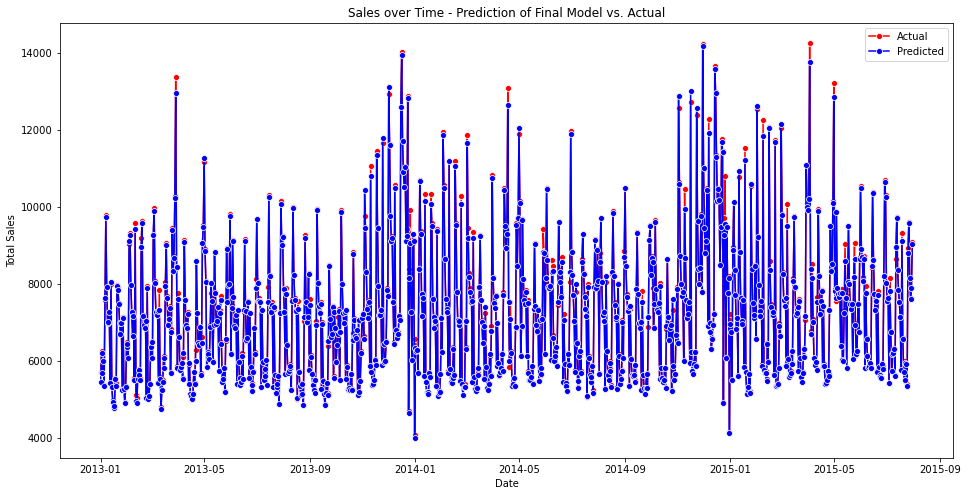

In [57]:
# Plot of y_true vs y_pred:
df_grouped = df_pred.resample('D').mean().reset_index()  # Aggregation of data

plt.figure(figsize=(16, 8)) 

sns.lineplot(data=df_grouped, x='Date', y='y_true', color='red', label='Actual', marker='o')
sns.lineplot(data=df_grouped, x='Date', y='y_pred', color='blue', label='Predicted', marker='o')

# Edytuj wykres
plt.title('Sales over Time - Prediction of Final Model vs. Actual')
plt.xlabel('Date')
plt.ylabel('Total Sales')

plt.show()

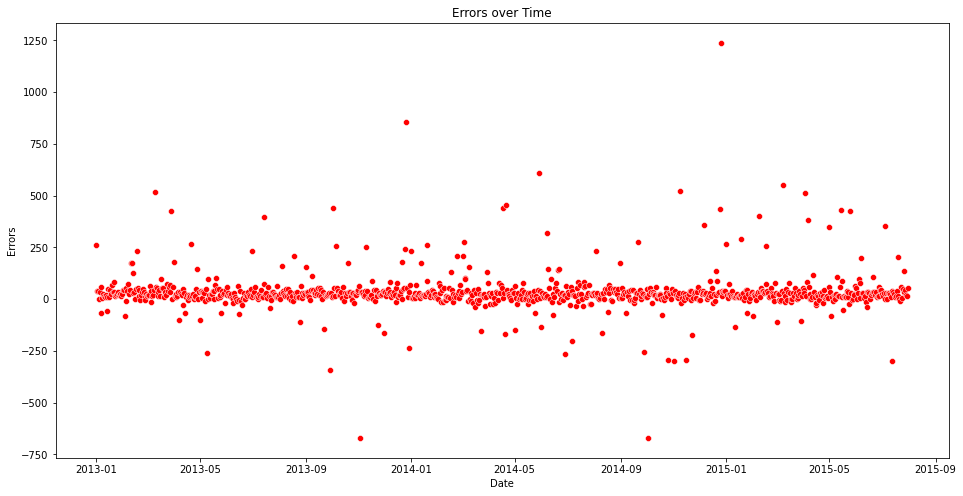

In [58]:
#Plot of residual errors:

df_grouped = df_pred.resample('D').mean().reset_index() #Aggregation of data

plt.figure(figsize=(16, 8))

sns.scatterplot(data=df_grouped, x='Date', y='errors', color='red', marker='o')

# Edytuj wykres
plt.title('Errors over Time')
plt.xlabel('Date')
plt.ylabel('Errors')

plt.show()

**Commnets:**

Upon initial observation, the predictions appear to be satisfactory. However, analyzing the residual errors plot, significant outliers emerge, particularly in seasonal periods, such as the middle of the last quarter and towards the end of the year. 

This suggests that **the model could be improved, possibly by incorporating more advanced features to capture seasonal patterns more accurately.** As noted during the exploratory data analysis (EDA), there were indications of seasonal patterns.
____

## Real Model Test on Unseen Data with Kaggle

In [59]:
# Number of Weeks to Predict Sales:

print(f'Number of weeks to predict: {round((df_test.Date.max() - df_test.Date.min()) / timedelta(weeks=1),1)}')

Number of weeks to predict: 6.7


In [60]:
# Selected models to check:
# Please note that all selected models were train and fitted with StandardSplit approach before.

pipes_to_check = [pipe_rf_tuned, pipe_lgbmr_tuned, pipe_xgb_tuned]

In [ ]:
#Function for Generating Kaggle CSV Submission File and initial 
#Steps for Preparing Function or Pipeline for Deployment

def kaggle_test(df_test : pd.DataFrame, 
                X_trained: pd.DataFrame = X_train, 
                top_pipes: Pipeline = None) -> None:
    """
    The kaggle_test function is designed to create a Kaggle CSV submission file. It takes a test 
    dataframe and a list of selected models as input. This function performs essential data preprocessing steps, 
    makes predictions using the trained models, and saves the results as CSV files for each model.

    Args:
        df_test (pd.DataFrame): The test dataframe to be used for making predictions.
        X_trained (pd.DataFrame, optional): The trained input features dataframe. Defaults to X_train.
        top_pipes (List[Pipeline], optional): The list of selected models. Defaults to None.

    Returns:
    None, save prediction files for Kaggle test.

    """
    
    # Fill missing values in the 'Open' column with 1:
    df_test['Open'].fillna(1, inplace=True)
    
    # Merge with store information dataframe:
    df_test_kaggle = df_test.merge(right=df_store, on="Store", how="left").fillna(0)
    
    # Add new features:
    extract_dates(df_test_kaggle)
    comp_open_months(df_test_kaggle)
    promo_open(df_test_kaggle)
    promo_2_flag(df_test_kaggle)
    
    # Optimize data types:
    utl.optimize(df_test_kaggle, 
                 datetime_features=['Date'], 
                 bool_features=['Open', 'Promo', 'Promo2', 'StateHoliday', 'SchoolHoliday'])
    
    # Prepare new X:
    X_new = df_test_kaggle[X_train.columns]
    
    for pipe in top_pipes:
        # Make new predictions:
        kaggle_pred = pipe.predict(X_new)
        
        # Prepare results:
        result = pd.DataFrame({"Id": df_test_kaggle["Id"], 'Sales': kaggle_pred})
        result.to_csv(f"AdamKacprzycki_kaggle_{(type(pipe[-1].regressor_).__name__)}.csv", index=False)

        print(f"AdamKacprzycki_kaggle_{(type(pipe[-1].regressor_).__name__)}.csv was succesfully saved.")

In [ ]:
kaggle_test(df_test, X_trained=X_train, top_pipes=pipes_to_check)

______

##  Final results:

In general on kaggle, the private score (score) is typically a more accurate measure of model performance as it represents how well the models generalize to unseen data.

<!-- <table>
  <tr>
    <th>Model</th>
    <th>Public Score</th>
    <th>Private Score</th>
    <th>Score</th>
  </tr>
  <tr>
    <td>LGBMRegressor</td>
    <td>0.11634</td>
    <td>0.12823</td>
    <td>0.11634</td>
  </tr>
  <tr>
    <td>XGBRegressor</td>
    <td>0.11666</td>
    <td>0.12769</td>
    <td>0.11666</td>
  </tr>
  <tr>
    <td>RandomForestRegressor</td>
    <td>0.13214</td>
    <td>0.14568</td>
    <td>0.13214</td>
  </tr>
</table> -->

![](kaggle_subm_results/kaggle_results.png)
____

_____

##  Saving models:
[benchmarks_saving_models](https://gael-varoquaux.info/programming/new_low-overhead_persistence_in_joblib_for_big_data.html)

In [61]:
import joblib
import os

#print(f'joblib ver. {joblib.__version__}')

for pipe in pipes_to_check:
    # Path to save the file
    save_path = f'models/{(type(pipe[-1].regressor_).__name__)}.joblib'

    # Save the model
    joblib.dump(pipe, save_path)

In [62]:
# Load the model

lgbm_v1 = joblib.load('models/LGBMRegressor.joblib')

In [63]:
# Checking results:

lgbm_v1

Pipeline(steps=[('ordinal_encode',
                 OrdinalEncoder(cols=['StateHoliday'],
                                mapping=[{'col': 'StateHoliday',
                                          'data_type': dtype('bool'),
                                          'mapping': True    1
NaN    -2
dtype: int64}])),
                ('target_encode',
                 TargetEncoder(cols=['Store', 'StoreType', 'Assortment'])),
                ('scaler', StandardScaler()),
                ('regressor',
                 TransformedTargetRegressor(regressor=LGBMRegressor(colsample_bytree=0.8,
                                                                    learning_rate=0.2,
                                                                    max_depth=100,
                                                                    min_child_samples=80,
                                                                    n_estimators=2500,
                                                             

_____

#  Conclusions:

In this project, I undertook the challenge of analyzing real business data and addressing associated problems (Sales predction), following the standard practice of CRISP-DM. As an aspiring professional Data Scientist, this project presented a significant challenge. However, in my opinion, I achieved highly favorable results, with the RMSPE score of 0.11634 (LGBMRegressor, score form kaggle) compered to best solution 0.10021 on the LeaderBoard.

During the project, I trained approximately 20 models, including both basic and advanced ones, employing different approaches to splitting the training and testing data. **Surprisingly, I obtained superior results using the StandardSplit method as opposed to TimeSeriesSplit, which is typically recommended for TimeSeries modeling.** Nevertheless, TimeSeriesSplit provided more stable results, with lower coefficients of variance, despite yielding poorer RMSPE scores and exhibiting signs of overfitting.

**Moving forward, potential avenues for improving my solution could include the following:**

**a) Enhancing the model metrics:**

- Exploring the possibility of increasing the number of estimators for the XGBoost Regressor model and fine-tuning it using Bayesian methods such as hyperopt or optuna.
- Given the positive correlation between Sales and Customers features, developing additional models to predict customer numbers and subsequently combining them with the most promising model.
- Utilizing more advanced aggregated features to capture seasonal patterns effectively.
- Experimenting with more complex embedding and preparation models, including Deep Learning models.

**b) Streamlining the deployment process:**

- Designing a more comprehensive pipeline that encompasses all the necessary steps for training the model, including feature transformation and engineering.

**Throughout the project, I encountered several challenges, including:**

- Identifying seasonal patterns during the exploratory data analysis (EDA) phase but lacking the experience to incorporate more complex features like lags and moving averages due to concerns about data leakage for aggregated features. Having access to a mentor or more experienced individual would have been beneficial in navigating this issue.

- Selecting appropriate parameters for the models, which was hindered by my limited experience. Nonetheless, I acquired substantial knowledge by thoroughly analyzing available documentation.

- Coping with machine memory limitations and optimizing parameter hyper-tuning for improved effectiveness.

- Conducting numerous experiments with pipelines to achieve cleaner and more efficient code and workflows.
- "Curse of analysis" :). One challenge I faced was the inherent temptation to dive infinitely deeper into the EDA phase in search of more information. It is crucial to strike a balance between conducting thorough analysis and recognizing the point of diminishing returns.

By addressing these challenges and pursuing the suggested improvements, I believe my solution can reach even greater heights in terms of accuracy and efficiency.